当前工作目录：/root/autodl-tmp/图像处理
=== 开始全局超像素分析 ===
复合EDS图像尺寸：(768, 1024, 3)
✓ 已加载 Si 过滤后的元素面谱
✓ 已加载 Al 过滤后的元素面谱
✓ 已加载 Ca 过滤后的元素面谱
✓ 已加载 Na 过滤后的元素面谱
✓ 已加载 Mg 过滤后的元素面谱
✓ 已加载 Fe 过滤后的元素面谱
开始执行超像素分割...
生成了 9688 个超像素区域
正在提取超像素区域的元素信息...
处理元素：Si
处理元素：Al
处理元素：Ca
处理元素：Na
处理元素：Mg
处理元素：Fe
✓ Excel文件已保存：integrated_superpixel_analysis/SLIC_superpixel_analysis.xlsx
生成超像素可视化图像...
✓ 超像素分割图像已保存：integrated_superpixel_analysis/Superpixel_SLIC.jpg
展示分析结果...


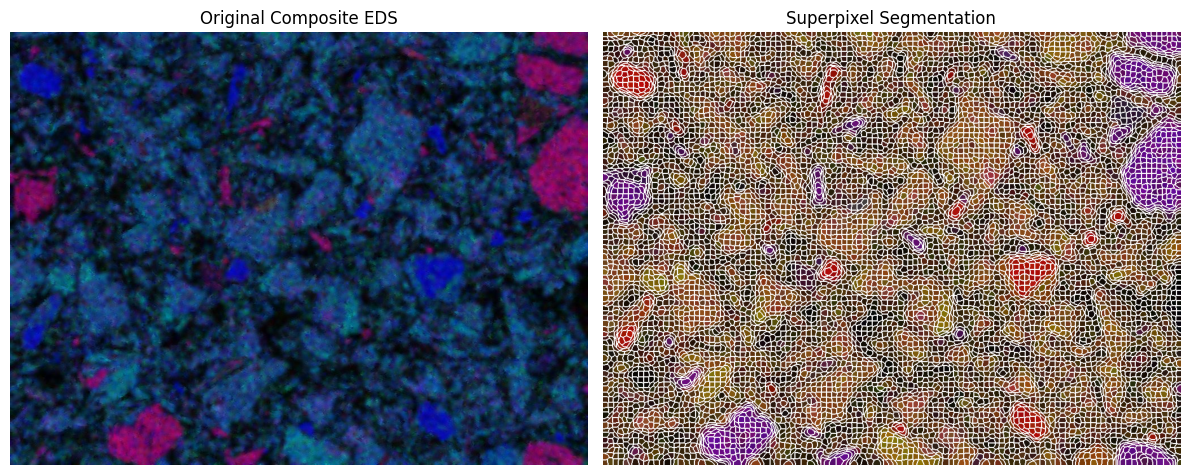


=== 分析统计信息 ===
总超像素区域数量：9688
处理的元素数量：6
Excel数据维度：(9688, 6)
结果文件夹：integrated_superpixel_analysis

=== 开始掩模超像素分析 ===
找到 6 个掩模文件

正在处理掩模：mask_1.jpg
在 mask_1.jpg 区域内生成了 378 个超像素区域
✓ mask_1 分析完成
  - Excel文件：mask_superpixel_analysis/mask_1_superpixel_analysis.xlsx
  - 图像文件：mask_superpixel_analysis/mask_1_superpixel.jpg

正在处理掩模：mask_2.jpg
在 mask_2.jpg 区域内生成了 356 个超像素区域
✓ mask_2 分析完成
  - Excel文件：mask_superpixel_analysis/mask_2_superpixel_analysis.xlsx
  - 图像文件：mask_superpixel_analysis/mask_2_superpixel.jpg

正在处理掩模：mask_3.jpg
在 mask_3.jpg 区域内生成了 454 个超像素区域
✓ mask_3 分析完成
  - Excel文件：mask_superpixel_analysis/mask_3_superpixel_analysis.xlsx
  - 图像文件：mask_superpixel_analysis/mask_3_superpixel.jpg

正在处理掩模：mask_4.jpg
在 mask_4.jpg 区域内生成了 329 个超像素区域
✓ mask_4 分析完成
  - Excel文件：mask_superpixel_analysis/mask_4_superpixel_analysis.xlsx
  - 图像文件：mask_superpixel_analysis/mask_4_superpixel.jpg

正在处理掩模：mask_5.jpg
在 mask_5.jpg 区域内生成了 471 个超像素区域
✓ mask_5 分析完成
  - Excel文件：mask_superpixel_analysis/mask_5_superpixe

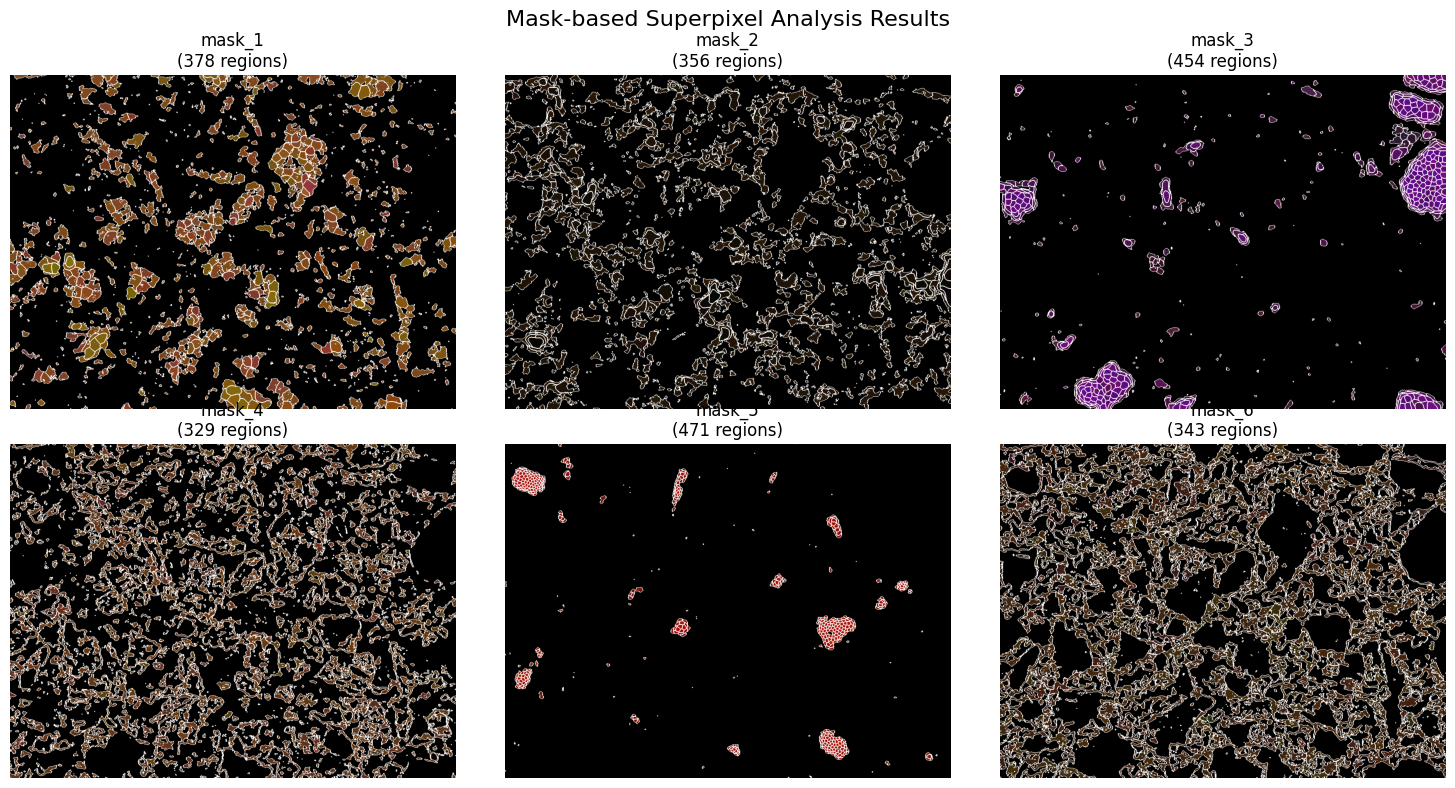


=== 掩模分析统计 ===
mask_1: 378 个超像素区域
mask_2: 356 个超像素区域
mask_3: 454 个超像素区域
mask_4: 329 个超像素区域
mask_5: 471 个超像素区域
mask_6: 343 个超像素区域

所有分析完成！


In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
from skimage import segmentation, color
import pandas as pd
import os

def integrated_superpixel_analysis():
    """
    整合的超像素分析：生成Excel文件 + 可视化展示（简化版）
    """
    # -------------------------- 1. 文件路径配置 --------------------------
    composite_path = "Composite.jpg"
    filtered_folder = "filtered_elements"
    output_folder = "integrated_superpixel_analysis"
    
    elements = ["Si", "Al", "Ca", "Na", "Mg", "Fe"]
    
    os.makedirs(output_folder, exist_ok=True)
    
    # -------------------------- 2. 读取复合EDS图像 --------------------------
    Composite_EDS = cv2.imread(composite_path, -1)
    if Composite_EDS is None:
        raise FileNotFoundError(f"未找到复合图像：{composite_path}")
    
    print(f"复合EDS图像尺寸：{Composite_EDS.shape}")
    
    # -------------------------- 3. 读取过滤后的元素面谱 --------------------------
    element_data = {}
    for element in elements:
        element_path = os.path.join(filtered_folder, f"{element}_Filter.jpg")
        img = cv2.imread(element_path, 0)
        if img is not None:
            element_data[element] = img
            print(f"✓ 已加载 {element} 过滤后的元素面谱")
        else:
            print(f"✗ 未找到 {element} 元素面谱：{element_path}")
    
    if len(element_data) == 0:
        raise FileNotFoundError("未找到任何元素面谱图像")
    
    # -------------------------- 4. 执行超像素分割 --------------------------
    print("开始执行超像素分割...")
    regions = segmentation.slic(
        Composite_EDS, 
        n_segments=10000, 
        compactness=10, 
        sigma=5, 
        start_label=1
    )
    
    num_regions = np.max(regions)
    print(f"生成了 {num_regions} 个超像素区域")
    
    # -------------------------- 5. 提取每个超像素区域的元素信息 --------------------------
    print("正在提取超像素区域的元素信息...")
    results = {}
    
    for element, mapping in element_data.items():
        print(f"处理元素：{element}")
        intensity_values = []
        
        for region in range(1, num_regions + 1):
            mask_region = (regions == region)
            if np.sum(mask_region) > 0:
                mean_intensity = np.mean(mapping[mask_region])
                intensity_values.append(mean_intensity)
            else:
                intensity_values.append(0)
        
        results[element] = intensity_values
    
    # -------------------------- 6. 创建并保存Excel文件 --------------------------
    df = pd.DataFrame(results)
    excel_path = os.path.join(output_folder, "SLIC_superpixel_analysis.xlsx")
    df.to_excel(excel_path, index=False)  # 改为Excel格式
    print(f"✓ Excel文件已保存：{excel_path}")
    
    # -------------------------- 7. 生成超像素可视化图像 --------------------------
    print("生成超像素可视化图像...")
    
    # 生成平均颜色的超像素图像（保持原始颜色）
    EDS = color.label2rgb(regions, Composite_EDS, kind='avg')
    
    # 添加边界线
    boundary_image = segmentation.mark_boundaries(EDS, regions, (1, 1, 1))
    
    # 修复保存格式问题
    boundary_image_uint8 = (boundary_image * 255).astype(np.uint8)
    slic_path = os.path.join(output_folder, "Superpixel_SLIC.jpg")
    cv2.imwrite(slic_path, boundary_image_uint8)
    print(f"✓ 超像素分割图像已保存：{slic_path}")
    
    # -------------------------- 8. 简化的展示结果图像 --------------------------
    print("展示分析结果...")
    
    plt.figure(figsize=(12, 6))
    
    # 子图1：原始复合图像
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(Composite_EDS, cv2.COLOR_BGR2RGB))
    plt.title('Original Composite EDS')
    plt.axis('off')
    
    # 子图2：超像素分割结果
    plt.subplot(1, 2, 2)
    plt.imshow(boundary_image)
    plt.title('Superpixel Segmentation')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # -------------------------- 9. 统计信息 --------------------------
    print("\n=== 分析统计信息 ===")
    print(f"总超像素区域数量：{num_regions}")
    print(f"处理的元素数量：{len(element_data)}")
    print(f"Excel数据维度：{df.shape}")
    print(f"结果文件夹：{output_folder}")
    
    return df, regions, boundary_image

def mask_based_superpixel_analysis():
    """
    基于每个GMM掩模的超像素聚类分析
    """
    # -------------------------- 1. 文件路径配置 --------------------------
    composite_path = "Composite.jpg"
    filtered_folder = "filtered_elements"
    gmm_folder = "GMM clustering results"
    output_folder = "mask_superpixel_analysis"
    
    elements = ["Si", "Al", "Ca", "Na", "Mg", "Fe"]
    
    os.makedirs(output_folder, exist_ok=True)
    
    # -------------------------- 2. 检查必要文件 --------------------------
    if not os.path.exists(gmm_folder):
        print(f"未找到GMM掩模文件夹：{gmm_folder}")
        return {}
    
    # 读取复合EDS图像
    Composite_EDS = cv2.imread(composite_path, -1)
    if Composite_EDS is None:
        print(f"未找到复合图像：{composite_path}")
        return {}
    
    # 读取过滤后的元素面谱
    element_data = {}
    for element in elements:
        element_path = os.path.join(filtered_folder, f"{element}_Filter.jpg")
        img = cv2.imread(element_path, 0)
        if img is not None:
            element_data[element] = img
    
    if len(element_data) == 0:
        print("未找到任何元素面谱图像")
        return {}
    
    # -------------------------- 3. 获取所有掩模文件 --------------------------
    mask_files = [f for f in os.listdir(gmm_folder) if f.startswith('mask_') and f.endswith('.jpg')]
    mask_files.sort()  # 按文件名排序
    
    if not mask_files:
        print("未找到掩模文件")
        return {}
    
    print(f"找到 {len(mask_files)} 个掩模文件")
    
    # -------------------------- 4. 批量处理每个掩模 --------------------------
    all_mask_results = {}
    
    for mask_file in mask_files:
        mask_path = os.path.join(gmm_folder, mask_file)
        mask_name = os.path.splitext(mask_file)[0]
        
        print(f"\n正在处理掩模：{mask_file}")
        
        # 读取并处理掩模
        phase_mask = cv2.imread(mask_path, 0)
        if phase_mask is None:
            print(f"无法读取掩模：{mask_path}")
            continue
        
        # 二值化处理掩模
        phase_mask[phase_mask > 200] = 255
        phase_mask[phase_mask < 50] = 0
        
        # 检查掩模是否为空
        if np.sum(phase_mask) == 0:
            print(f"掩模 {mask_file} 为空，跳过")
            continue
        
        # 在指定掩模区域内进行超像素分割
        try:
            regions = segmentation.slic(
                Composite_EDS, 
                n_segments=500,  # 掩模区域用较少的超像素
                compactness=10, 
                sigma=5, 
                start_label=1, 
                mask=phase_mask
            )
            
            num_regions = np.max(regions)
            if num_regions == 0:
                print(f"掩模 {mask_file} 未生成有效超像素区域")
                continue
                
            print(f"在 {mask_file} 区域内生成了 {num_regions} 个超像素区域")
            
            # 提取每个超像素区域的元素信息
            results = {}
            for element, mapping in element_data.items():
                intensity_values = []
                for region in range(1, num_regions + 1):
                    mask_region = (regions == region)
                    if np.sum(mask_region) > 0:
                        mean_intensity = np.mean(mapping[mask_region])
                        intensity_values.append(mean_intensity)
                    else:
                        intensity_values.append(0)
                results[element] = intensity_values
            
            # 创建DataFrame并保存
            df = pd.DataFrame(results)
            excel_path = os.path.join(output_folder, f"{mask_name}_superpixel_analysis.xlsx")
            df.to_excel(excel_path, index=False)
            
            # 生成可视化图像
            EDS_mask = color.label2rgb(regions, Composite_EDS, kind='avg')
            boundary_image = segmentation.mark_boundaries(EDS_mask, regions, (1, 1, 1))
            
            # 保存超像素分割图像
            boundary_image_uint8 = (boundary_image * 255).astype(np.uint8)
            slic_path = os.path.join(output_folder, f"{mask_name}_superpixel.jpg")
            cv2.imwrite(slic_path, boundary_image_uint8)
            
            all_mask_results[mask_name] = {
                'dataframe': df,
                'boundary_image': boundary_image,
                'num_regions': num_regions,
                'excel_path': excel_path,
                'image_path': slic_path
            }
            
            print(f"✓ {mask_name} 分析完成")
            print(f"  - Excel文件：{excel_path}")
            print(f"  - 图像文件：{slic_path}")
            
        except Exception as e:
            print(f"处理掩模 {mask_file} 时出错：{str(e)}")
            continue
    
    return all_mask_results

def visualize_mask_results(mask_results):
    """
    可视化掩模分析结果
    """
    if not mask_results:
        print("没有掩模分析结果可以显示")
        return
    
    n_masks = len(mask_results)
    print(f"\n展示 {n_masks} 个掩模的超像素分析结果...")
    
    # 计算显示布局
    cols = min(3, n_masks)
    rows = (n_masks + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    fig.suptitle('Mask-based Superpixel Analysis Results', fontsize=16)
    
    if n_masks == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if cols == 1 else list(axes)
    else:
        axes = axes.flatten()
    
    for i, (mask_name, data) in enumerate(mask_results.items()):
        if i < len(axes):
            axes[i].imshow(data['boundary_image'])
            axes[i].set_title(f'{mask_name}\n({data["num_regions"]} regions)')
            axes[i].axis('off')
    
    # 隐藏多余的子图
    for j in range(len(mask_results), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# 主程序执行
if __name__ == "__main__":
    print(f"当前工作目录：{os.getcwd()}")
    
    # 检查必要文件
    if not os.path.exists("Composite.jpg"):
        print("缺少Composite.jpg文件")
        exit()
    
    if not os.path.exists("filtered_elements"):
        print("缺少filtered_elements文件夹")
        exit()
    
    try:
        # 执行全局超像素分析
        print("=== 开始全局超像素分析 ===")
        df_global, regions_global, boundary_global = integrated_superpixel_analysis()
        
        # 执行每个掩模的超像素分析
        print("\n=== 开始掩模超像素分析 ===")
        mask_results = mask_based_superpixel_analysis()
        
        if mask_results:
            # 显示掩模分析结果
            visualize_mask_results(mask_results)
            
            # 显示统计信息
            print(f"\n=== 掩模分析统计 ===")
            for mask_name, data in mask_results.items():
                print(f"{mask_name}: {data['num_regions']} 个超像素区域")
        
        print("\n所有分析完成！")
        
    except Exception as e:
        print(f"分析过程中出错：{str(e)}")


开始处理全局超像素分析数据...
使用阈值 Si >= 25 进行过滤...
✓ 成功读取原始数据：(9688, 6)
原始数据列名：['Si', 'Al', 'Ca', 'Na', 'Mg', 'Fe']

=== 过滤前统计信息 ===
总数据点数量：9688
Si列统计信息：
count    9688.000000
mean       50.359050
std        24.782309
min         0.012346
25%        31.940449
50%        47.035897
75%        66.620340
max       161.396226
Name: Si, dtype: float64
Si < 25 的数据点数量：1443
Si >= 25 的数据点数量：8245

=== 过滤后统计信息 ===
过滤后数据点数量：8245
移除的数据点数量：1443
数据保留率：85.11%
过滤后Si列统计信息：
count    8245.000000
mean       56.135036
std        22.192524
min        25.000000
25%        38.518519
50%        52.453488
75%        70.048387
max       161.396226
Name: Si, dtype: float64
✓ 过滤后的数据已保存：filtered_global_analysis/SLIC_superpixel_analysis_Si_filtered_25.xlsx
✓ 过滤报告已保存：filtered_global_analysis/filtering_report_Si_25.txt


/tmp/ipykernel_3403/4131719645.py:196: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3403/4131719645.py:196: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3403/4131719645.py:196: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3403/4131719645.py:196: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3403/4131719645.py:196: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3403/4131719645.py:196: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3403/4131719645.py:196: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.

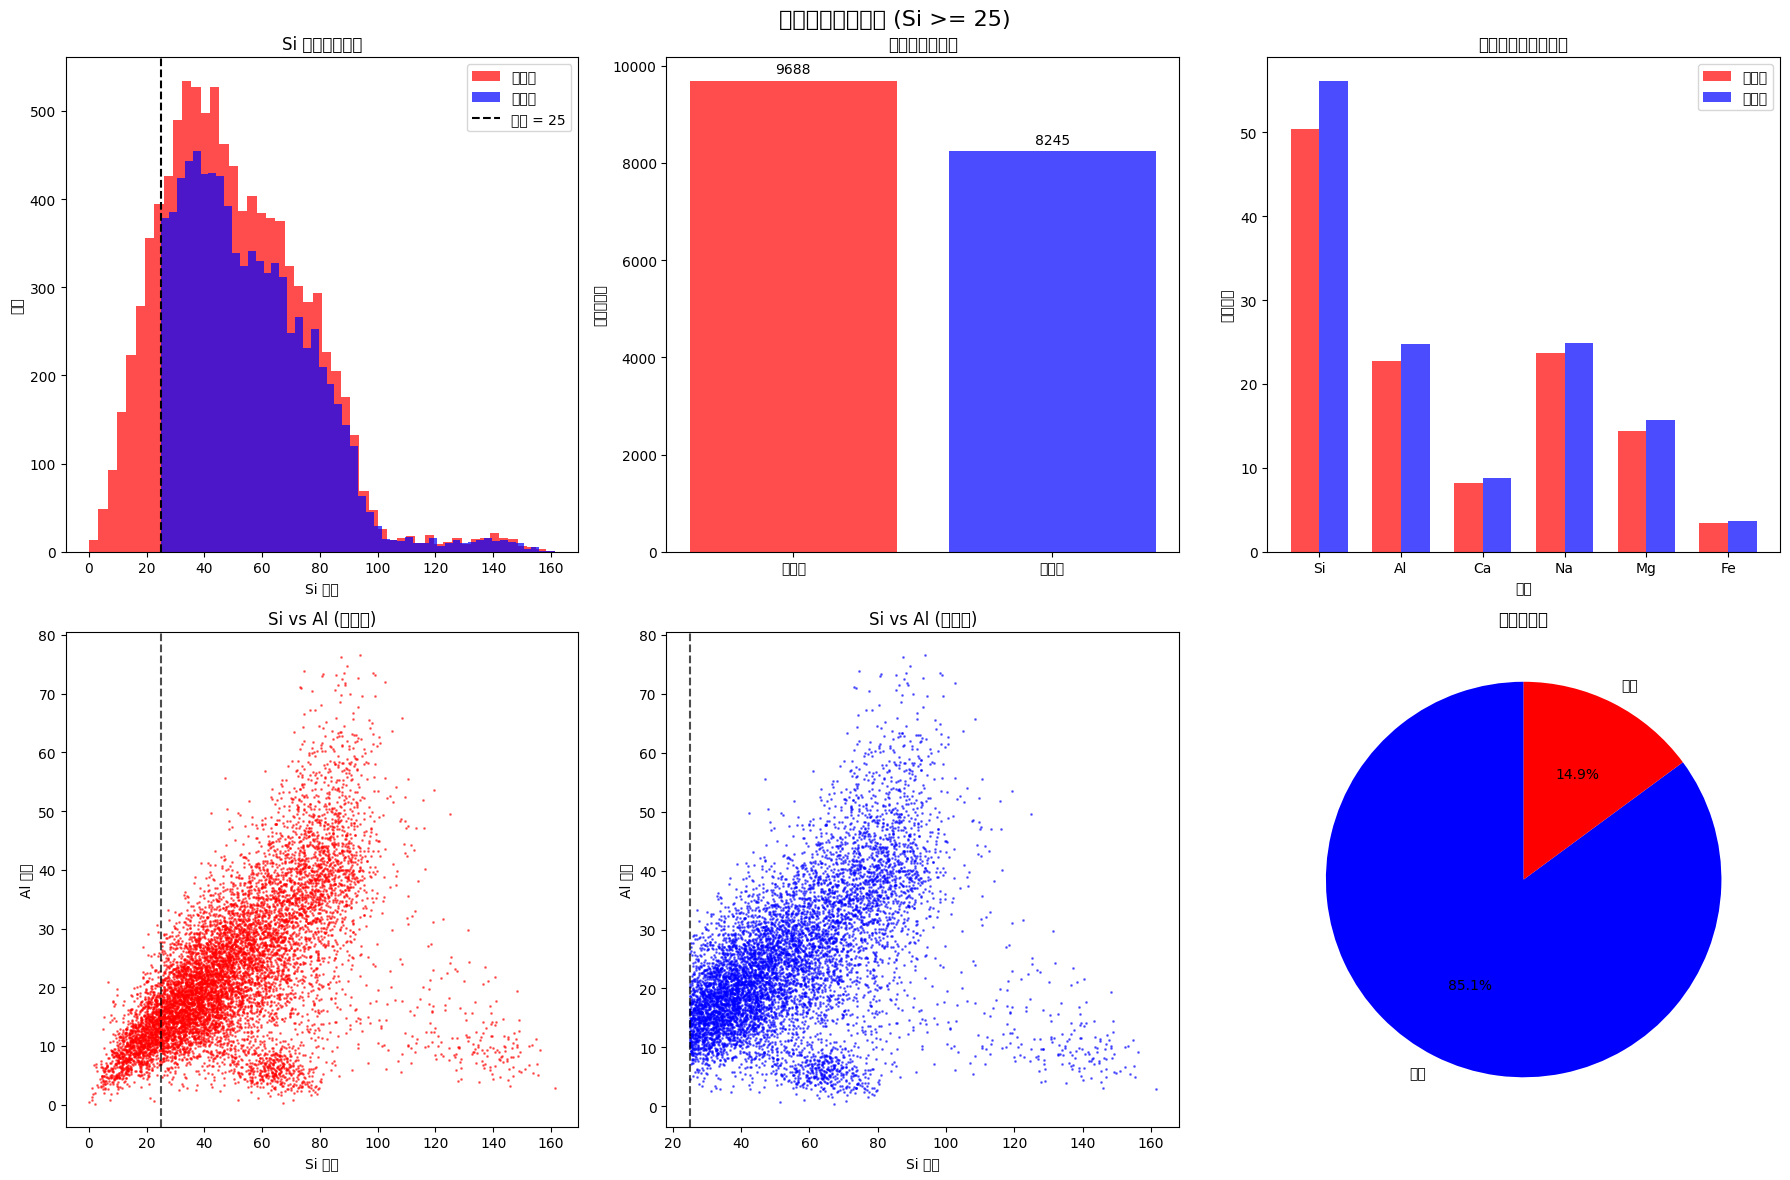


是否要进行多个阈值的批量分析？


输入 'y' 或 'yes' 进行批量分析，其他任意键跳过： y


=== 批量过滤分析 ===

--- 处理阈值：Si >= 20 ---
✓ 成功读取原始数据：(9688, 6)
原始数据列名：['Si', 'Al', 'Ca', 'Na', 'Mg', 'Fe']

=== 过滤前统计信息 ===
总数据点数量：9688
Si列统计信息：
count    9688.000000
mean       50.359050
std        24.782309
min         0.012346
25%        31.940449
50%        47.035897
75%        66.620340
max       161.396226
Name: Si, dtype: float64
Si < 20 的数据点数量：876
Si >= 20 的数据点数量：8812

=== 过滤后统计信息 ===
过滤后数据点数量：8812
移除的数据点数量：876
数据保留率：90.96%
过滤后Si列统计信息：
count    8812.000000
mean       53.970409
std        23.002008
min        20.000000
25%        35.930475
50%        50.060731
75%        68.535593
max       161.396226
Name: Si, dtype: float64
✓ 过滤后的数据已保存：filtered_global_analysis/SLIC_superpixel_analysis_Si_filtered_20.xlsx
✓ 过滤报告已保存：filtered_global_analysis/filtering_report_Si_20.txt

--- 处理阈值：Si >= 25 ---
✓ 成功读取原始数据：(9688, 6)
原始数据列名：['Si', 'Al', 'Ca', 'Na', 'Mg', 'Fe']

=== 过滤前统计信息 ===
总数据点数量：9688
Si列统计信息：
count    9688.000000
mean       50.359050
std        24.782309
min         0.012346
25%       

In [10]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def filter_global_excel_data(threshold=30):
    """
    过滤全局超像素分析的Excel文件，移除Si小于指定阈值的数据点
    
    Parameters:
    threshold (float): Si强度的阈值，默认为30
    """
    # -------------------------- 1. 文件路径配置 --------------------------
    input_folder = "integrated_superpixel_analysis"
    output_folder = "filtered_global_analysis"
    input_file = "SLIC_superpixel_analysis.xlsx"
    
    os.makedirs(output_folder, exist_ok=True)
    
    # -------------------------- 2. 读取原始Excel文件 --------------------------
    input_path = os.path.join(input_folder, input_file)
    
    if not os.path.exists(input_path):
        print(f"错误：未找到输入文件 {input_path}")
        return None, None
    
    try:
        df_original = pd.read_excel(input_path)
        print(f"✓ 成功读取原始数据：{df_original.shape}")
        print(f"原始数据列名：{list(df_original.columns)}")
    except Exception as e:
        print(f"读取Excel文件时出错：{str(e)}")
        return None, None
    
    # -------------------------- 3. 检查Si列是否存在 --------------------------
    if 'Si' not in df_original.columns:
        print("错误：数据中未找到'Si'列")
        print(f"可用列：{list(df_original.columns)}")
        return None, None
    
    # -------------------------- 4. 数据过滤前的统计信息 --------------------------
    print(f"\n=== 过滤前统计信息 ===")
    print(f"总数据点数量：{len(df_original)}")
    print(f"Si列统计信息：")
    print(df_original['Si'].describe())
    print(f"Si < {threshold} 的数据点数量：{len(df_original[df_original['Si'] < threshold])}")
    print(f"Si >= {threshold} 的数据点数量：{len(df_original[df_original['Si'] >= threshold])}")
    
    # -------------------------- 5. 执行数据过滤 --------------------------
    # 保留Si >= threshold的数据点
    df_filtered = df_original[df_original['Si'] >= threshold].copy()
    
    # 重置索引
    df_filtered.reset_index(drop=True, inplace=True)
    
    # -------------------------- 6. 过滤后的统计信息 --------------------------
    print(f"\n=== 过滤后统计信息 ===")
    print(f"过滤后数据点数量：{len(df_filtered)}")
    print(f"移除的数据点数量：{len(df_original) - len(df_filtered)}")
    print(f"数据保留率：{len(df_filtered)/len(df_original)*100:.2f}%")
    
    if len(df_filtered) > 0:
        print(f"过滤后Si列统计信息：")
        print(df_filtered['Si'].describe())
    else:
        print("警告：过滤后没有剩余数据点！")
        return df_original, df_filtered
    
    # -------------------------- 7. 保存过滤后的数据 --------------------------
    output_file = f"SLIC_superpixel_analysis_Si_filtered_{threshold}.xlsx"
    output_path = os.path.join(output_folder, output_file)
    
    try:
        df_filtered.to_excel(output_path, index=False)
        print(f"✓ 过滤后的数据已保存：{output_path}")
    except Exception as e:
        print(f"保存Excel文件时出错：{str(e)}")
    
    # -------------------------- 8. 生成对比统计报告 --------------------------
    report_file = f"filtering_report_Si_{threshold}.txt"
    report_path = os.path.join(output_folder, report_file)
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("超像素数据过滤报告\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"过滤条件：Si >= {threshold}\n")
        f.write(f"原始数据文件：{input_path}\n")
        f.write(f"过滤后文件：{output_path}\n\n")
        
        f.write("数据统计：\n")
        f.write(f"原始数据点数量：{len(df_original)}\n")
        f.write(f"过滤后数据点数量：{len(df_filtered)}\n")
        f.write(f"移除的数据点数量：{len(df_original) - len(df_filtered)}\n")
        f.write(f"数据保留率：{len(df_filtered)/len(df_original)*100:.2f}%\n\n")
        
        if len(df_filtered) > 0:
            f.write("各元素统计信息对比：\n")
            for col in df_original.columns:
                if col in df_filtered.columns:
                    f.write(f"\n{col}:\n")
                    f.write(f"  原始 - 均值: {df_original[col].mean():.2f}, 标准差: {df_original[col].std():.2f}\n")
                    f.write(f"  过滤后 - 均值: {df_filtered[col].mean():.2f}, 标准差: {df_filtered[col].std():.2f}\n")
    
    print(f"✓ 过滤报告已保存：{report_path}")
    
    return df_original, df_filtered

def visualize_filtering_results(df_original, df_filtered, threshold=30):
    """
    可视化过滤前后的数据对比
    """
    if df_original is None or df_filtered is None:
        print("无法进行可视化：数据为空")
        return
    
    # 设置图形样式
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'数据过滤对比分析 (Si >= {threshold})', fontsize=16)
    
    # 获取所有元素列
    elements = [col for col in df_original.columns if col in ['Si', 'Al', 'Ca', 'Na', 'Mg', 'Fe']]
    
    # 1. Si分布对比
    axes[0, 0].hist(df_original['Si'], bins=50, alpha=0.7, label='过滤前', color='red')
    if len(df_filtered) > 0:
        axes[0, 0].hist(df_filtered['Si'], bins=50, alpha=0.7, label='过滤后', color='blue')
    axes[0, 0].axvline(threshold, color='black', linestyle='--', label=f'阈值 = {threshold}')
    axes[0, 0].set_xlabel('Si 强度')
    axes[0, 0].set_ylabel('频次')
    axes[0, 0].set_title('Si 强度分布对比')
    axes[0, 0].legend()
    
    # 2. 数据点数量对比
    counts = [len(df_original), len(df_filtered)]
    labels = ['过滤前', '过滤后']
    colors = ['red', 'blue']
    bars = axes[0, 1].bar(labels, counts, color=colors, alpha=0.7)
    axes[0, 1].set_ylabel('数据点数量')
    axes[0, 1].set_title('数据点数量对比')
    
    # 添加数值标签
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{count}', ha='center', va='bottom')
    
    # 3. 各元素均值对比
    if len(elements) > 0 and len(df_filtered) > 0:
        original_means = [df_original[elem].mean() for elem in elements]
        filtered_means = [df_filtered[elem].mean() for elem in elements]
        
        x = np.arange(len(elements))
        width = 0.35
        
        axes[0, 2].bar(x - width/2, original_means, width, label='过滤前', color='red', alpha=0.7)
        axes[0, 2].bar(x + width/2, filtered_means, width, label='过滤后', color='blue', alpha=0.7)
        axes[0, 2].set_xlabel('元素')
        axes[0, 2].set_ylabel('平均强度')
        axes[0, 2].set_title('各元素平均强度对比')
        axes[0, 2].set_xticks(x)
        axes[0, 2].set_xticklabels(elements)
        axes[0, 2].legend()
    
    # 4. Si vs 其他元素散点图（过滤前）
    if len(elements) > 1:
        other_element = elements[1] if elements[1] != 'Si' else elements[0]
        axes[1, 0].scatter(df_original['Si'], df_original[other_element], 
                          alpha=0.5, color='red', s=1, label='过滤前')
        axes[1, 0].axvline(threshold, color='black', linestyle='--', alpha=0.7)
        axes[1, 0].set_xlabel('Si 强度')
        axes[1, 0].set_ylabel(f'{other_element} 强度')
        axes[1, 0].set_title(f'Si vs {other_element} (过滤前)')
    
    # 5. Si vs 其他元素散点图（过滤后）
    if len(elements) > 1 and len(df_filtered) > 0:
        axes[1, 1].scatter(df_filtered['Si'], df_filtered[other_element], 
                          alpha=0.5, color='blue', s=1, label='过滤后')
        axes[1, 1].axvline(threshold, color='black', linestyle='--', alpha=0.7)
        axes[1, 1].set_xlabel('Si 强度')
        axes[1, 1].set_ylabel(f'{other_element} 强度')
        axes[1, 1].set_title(f'Si vs {other_element} (过滤后)')
    
    # 6. 数据保留率饼图
    if len(df_filtered) > 0:
        retained = len(df_filtered)
        removed = len(df_original) - len(df_filtered)
        sizes = [retained, removed]
        labels_pie = ['保留', '移除']
        colors_pie = ['blue', 'red']
        
        axes[1, 2].pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
        axes[1, 2].set_title('数据保留率')
    
    plt.tight_layout()
    
    # 保存图像
    output_folder = "filtered_global_analysis"
    os.makedirs(output_folder, exist_ok=True)
    plt.savefig(os.path.join(output_folder, f'filtering_comparison_Si_{threshold}.jpg'), 
                dpi=300, bbox_inches='tight')
    plt.show()

def batch_filter_with_multiple_thresholds():
    """
    使用多个阈值批量过滤数据
    """
    thresholds = [20, 25, 30, 35, 40]
    
    print("=== 批量过滤分析 ===")
    results_summary = []
    
    for threshold in thresholds:
        print(f"\n--- 处理阈值：Si >= {threshold} ---")
        df_original, df_filtered = filter_global_excel_data(threshold)
        
        if df_original is not None and df_filtered is not None:
            retention_rate = len(df_filtered) / len(df_original) * 100
            results_summary.append({
                'threshold': threshold,
                'original_count': len(df_original),
                'filtered_count': len(df_filtered),
                'removed_count': len(df_original) - len(df_filtered),
                'retention_rate': retention_rate
            })
    
    # 保存批量分析结果
    if results_summary:
        summary_df = pd.DataFrame(results_summary)
        output_folder = "filtered_global_analysis"
        summary_path = os.path.join(output_folder, "batch_filtering_summary.xlsx")
        summary_df.to_excel(summary_path, index=False)
        
        print(f"\n=== 批量过滤汇总 ===")
        print(summary_df.to_string(index=False))
        print(f"✓ 批量分析汇总已保存：{summary_path}")

# 主程序执行
if __name__ == "__main__":
    print("开始处理全局超像素分析数据...")
    
    # 检查输入文件
    input_folder = "integrated_superpixel_analysis"
    input_file = "SLIC_superpixel_analysis.xlsx"
    
    if not os.path.exists(os.path.join(input_folder, input_file)):
        print(f"错误：未找到输入文件 {os.path.join(input_folder, input_file)}")
        print("请先运行全局超像素分析代码生成Excel文件")
        exit()
    
    try:
        # 单一阈值过滤
        threshold = 25  # 可以修改这个值
        print(f"使用阈值 Si >= {threshold} 进行过滤...")
        df_original, df_filtered = filter_global_excel_data(threshold)
        
        # 可视化结果
        if df_original is not None and df_filtered is not None:
            visualize_filtering_results(df_original, df_filtered, threshold)
        
        # 询问是否进行批量分析
        print("\n是否要进行多个阈值的批量分析？")
        user_input = input("输入 'y' 或 'yes' 进行批量分析，其他任意键跳过：").lower().strip()
        
        if user_input in ['y', 'yes']:
            batch_filter_with_multiple_thresholds()
        
        print("\n数据过滤完成！")
        
    except Exception as e:
        print(f"处理过程中出错：{str(e)}")
